## Acquisition Analytics

#### Importing all the libraries required

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score,confusion_matrix,log_loss,precision_score,recall_score
from sklearn.model_selection import cross_val_score,StratifiedKFold,GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report
import warnings
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline

C:\Users\sumasark\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\sumasark\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sumasark\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sumasark\Anaconda3\lib\site-packages\tensorflow\pytho

#### Importing the dataset and doing basic checks on them

In [2]:
bank_market = pd.read_csv('bank_marketing.csv',sep=',')

In [3]:
bank_market.shape

(41188, 21)

In [4]:
bank_market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
response          41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

In [5]:
bank_market.describe([0.25,0.50,0.75,0.99])

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
99%,71.00000,1271.130000,14.000000,999.000000,2.000000,1.400000,94.465000,-26.900000,4.968000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [6]:
round(bank_market.isnull().sum()/len(bank_market.index),2)

age               0.0
job               0.0
marital           0.0
education         0.0
default           0.0
housing           0.0
loan              0.0
contact           0.0
month             0.0
day_of_week       0.0
duration          0.0
campaign          0.0
pdays             0.0
previous          0.0
poutcome          0.0
emp.var.rate      0.0
cons.price.idx    0.0
cons.conf.idx     0.0
euribor3m         0.0
nr.employed       0.0
response          0.0
dtype: float64

In [7]:
bank_market.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'response'], dtype='object')

#### Label encoding manually for performing operations on the response variable

In [8]:
bank_market['response'] = bank_market['response'].map({'no':0,'yes':1})

#### Checking for class imbalence

In [9]:
round(bank_market['response'].value_counts()/len(bank_market),4)*100

0    88.73
1    11.27
Name: response, dtype: float64

#### Its recomended to create a copy of actual dataset

In [10]:
bank_market_cpy = bank_market

#### We can see using boxplot there are outliers in the age column so we are going to cap the data till 99 percentile

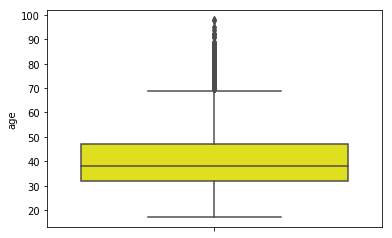

In [11]:
sns.boxplot(y = bank_market.age,color='yellow')
plt.show()

In [12]:
bank_market.age[bank_market.age>71]=71

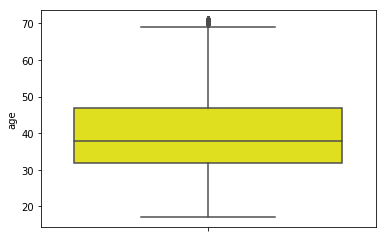

In [13]:
sns.boxplot(y = bank_market.age,color='yellow')

#### For analysis purpose lets create bins out of age columns

In [14]:
bins = np.arange(10,bank_market.age.max()+10,10)
bank_market['age_bins'] = pd.cut(bank_market.age,bins,include_lowest=True)

#### Creating a function which will increase code reusability

In [15]:
# Function to understand the relationship of independent variable with response variable
def analize(independent,response):
    No_of_prospect =bank_market.groupby(bank_market[independent])[response].count().reset_index(name='No.of_prospect')
    count_prospects=bank_market[bank_market[response]==1].groupby(bank_market[bank_market[response]==1][independent])[response].count().reset_index(name='count_prospects')
    agg_age = No_of_prospect.merge(count_prospects,on=independent)
    agg_age['response_rate'] = 100*(agg_age['count_prospects']/agg_age['No.of_prospect']).round(3)
    print('\033[1m'+'Analysis in table format'+'\033[1m')
    print(pd.DataFrame(agg_age))
    plt.title('Analysis of {0}'.format(independent))
    ax = sns.barplot(x=agg_age[independent], y='response_rate', data=agg_age)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    plt.show()

### Analysis on age

Analysis in table format
        age_bins  No.of_prospect  count_prospects  response_rate
0  (9.999, 20.0]             140               57           40.7
1   (20.0, 30.0]            7243             1067           14.7
2   (30.0, 40.0]           16385             1597            9.7
3   (40.0, 50.0]           10240              837            8.2
4   (50.0, 60.0]            6270              668           10.7
5   (60.0, 70.0]             488              212           43.4
6   (70.0, 80.0]             422              202           47.9


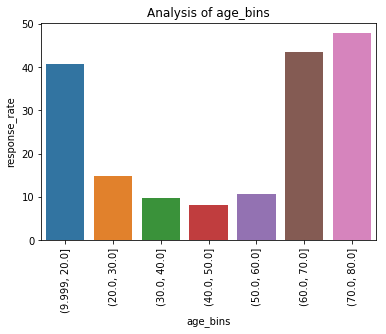

In [16]:
analize('age_bins','response')

#### The investment products are bought by young(by there father) and old after the retirement

### Analysis on Job

Analysis in table format
              job  No.of_prospect  count_prospects  response_rate
0          admin.           10422             1352           13.0
1     blue-collar            9254              638            6.9
2    entrepreneur            1456              124            8.5
3       housemaid            1060              106           10.0
4      management            2924              328           11.2
5         retired            1720              434           25.2
6   self-employed            1421              149           10.5
7        services            3969              323            8.1
8         student             875              275           31.4
9      technician            6743              730           10.8
10     unemployed            1014              144           14.2
11        unknown             330               37           11.2


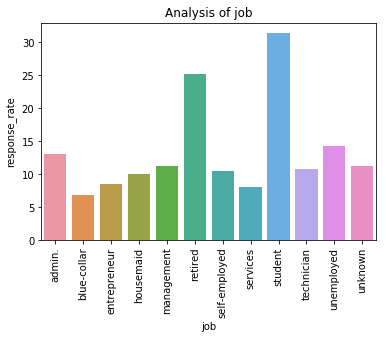

In [17]:
analize('job','response')
# bank_market

#### Here we can see the similar trend as previous graph the young student and the old retired persons have the highest response rates.

### Analysis on marital status

In [18]:
#### We will replace the unknown with the group having high frequency
print(bank_market.marital.value_counts())
bank_market.replace({'marital':{'unknown':'married'}},inplace=True)

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64


Analysis in table format
    marital  No.of_prospect  count_prospects  response_rate
0  divorced            4612              476           10.3
1   married           25008             2544           10.2
2    single           11568             1620           14.0


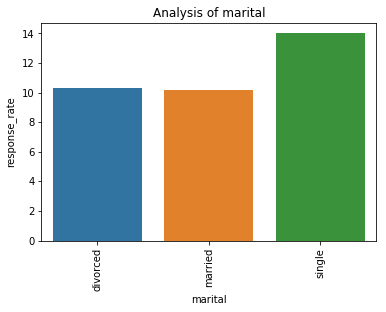

In [19]:
analize('marital','response')

#### Here we can see the unmarried person with age < 20 has a high response rate 

### Analysis on Education

In [20]:
bank_market.education.value_counts()

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

#### To simplify the problem, we are going to convert the educational qualifications to simple buckets of primary educations, secondary education, tertiary education and professional courses. Also note that there are 18 entries listing the educational status as illiterate. Since the closest group to them is primary education, we are going to assign all entries with educational status as illiterate to primary education.

In [21]:
bank_market.replace({'education' : { 'basic.9y' : 'Primary_Education', 'basic.4y' : 'Primary_Education','basic.6y' : 'Primary_Education','illiterate' : 'Primary_Education',
                             'high.school' : 'Secondary_Education', 'university.degree' : 'Tertiary_Education' }}, inplace=True)

Analysis in table format
             education  No.of_prospect  count_prospects  response_rate
0    Primary_Education           12531             1093            8.7
1  Secondary_Education            9515             1031           10.8
2   Tertiary_Education           12168             1670           13.7
3  professional.course            5243              595           11.3
4              unknown            1731              251           14.5


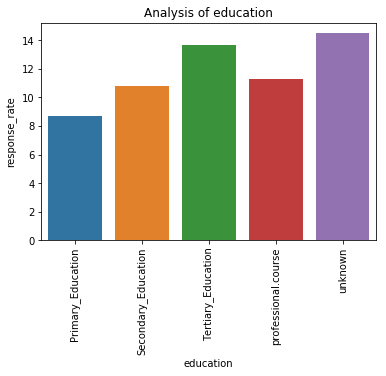

In [22]:
analize('education','response')

#### You can note that the response rate is lowest for people with highest education qualification as primary education, which may be attributed, in part, to lack of awareness and a lack of trust between the bank and the customer. It is the highest for people with tertiary education

### Previous default analysis 

In [23]:
bank_market.default.value_counts()

no         32588
unknown     8597
yes            3
Name: default, dtype: int64

Analysis in table format
   default  No.of_prospect  count_prospects  response_rate
0       no           32588             4197           12.9
1  unknown            8597              443            5.2


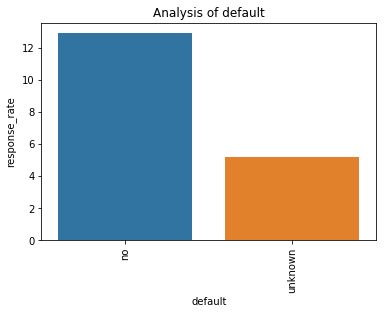

In [24]:
analize('default','response')

#### We can see there is no response for the defaulted customers

### Analysis on housing

In [25]:
bank_market.housing.value_counts()

yes        21576
no         18622
unknown      990
Name: housing, dtype: int64

Analysis in table format
   housing  No.of_prospect  count_prospects  response_rate
0       no           18622             2026           10.9
1  unknown             990              107           10.8
2      yes           21576             2507           11.6


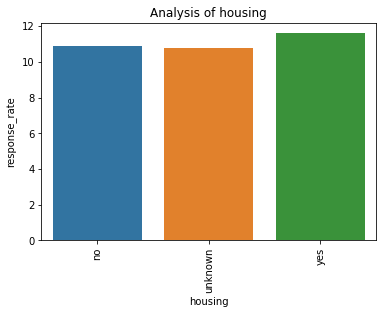

In [26]:
analize('housing','response')

### Analysis on loan

In [27]:
bank_market.loan.value_counts()

no         33950
yes         6248
unknown      990
Name: loan, dtype: int64

Analysis in table format
      loan  No.of_prospect  count_prospects  response_rate
0       no           33950             3850           11.3
1  unknown             990              107           10.8
2      yes            6248              683           10.9


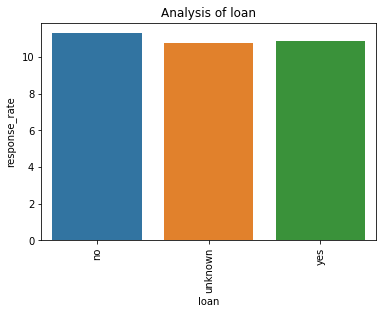

In [28]:
analize('loan','response')

#### As you can see there seems to be very little correlation between a prospect having a personal loan and the likelihood of him/her responding positively to the investment product

In [29]:
bank_market.contact.value_counts()

cellular     26144
telephone    15044
Name: contact, dtype: int64

Analysis in table format
     contact  No.of_prospect  count_prospects  response_rate
0   cellular           26144             3853           14.7
1  telephone           15044              787            5.2


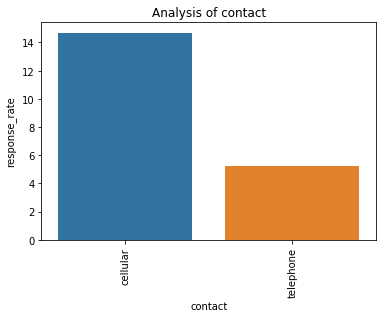

In [30]:
analize('contact','response')

#### You can see that the prospective customers contacted through cellular medium are significantly ore likely to opt in to the investment scheme compared to customers contacted through telephonic medium.

### Analysis on month

In [31]:
bank_market.month.value_counts()

may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546
dec      182
Name: month, dtype: int64

Analysis in table format
  month  No.of_prospect  count_prospects  response_rate
0   apr            2632              539           20.5
1   aug            6178              655           10.6
2   dec             182               89           48.9
3   jul            7174              649            9.0
4   jun            5318              559           10.5
5   mar             546              276           50.5
6   may           13769              886            6.4
7   nov            4101              416           10.1
8   oct             718              315           43.9
9   sep             570              256           44.9


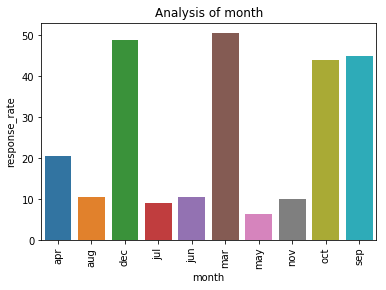

In [32]:
analize('month','response')

#### Here we can see that the response rate is very high for december,march,october and september

In [33]:
bank_market.day_of_week.value_counts()

thu    8623
mon    8514
wed    8134
tue    8090
fri    7827
Name: day_of_week, dtype: int64

Analysis in table format
  day_of_week  No.of_prospect  count_prospects  response_rate
0         fri            7827              846           10.8
1         mon            8514              847            9.9
2         thu            8623             1045           12.1
3         tue            8090              953           11.8
4         wed            8134              949           11.7


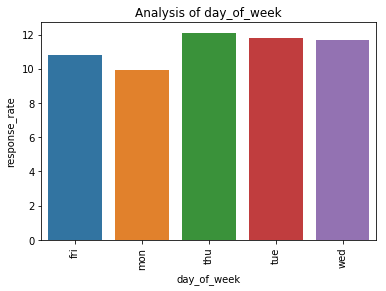

In [34]:
analize('day_of_week','response')

#### This variable is not explaining that much as we can see the values are vary close

In [35]:
bank_market.campaign.value_counts()

1     17642
2     10570
3      5341
4      2651
5      1599
6       979
7       629
8       400
9       283
10      225
11      177
12      125
13       92
14       69
17       58
15       51
16       51
18       33
20       30
19       26
21       24
22       17
23       16
24       15
27       11
29       10
25        8
26        8
28        8
30        7
31        7
35        5
33        4
32        4
34        3
40        2
42        2
43        2
37        1
39        1
41        1
56        1
Name: campaign, dtype: int64

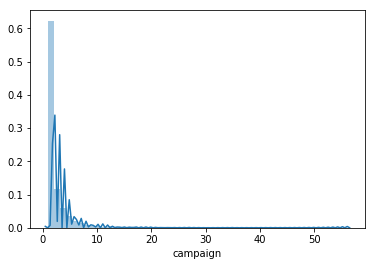

In [36]:
# Lets see the distribution
sns.distplot(bank_market.campaign)
plt.show()

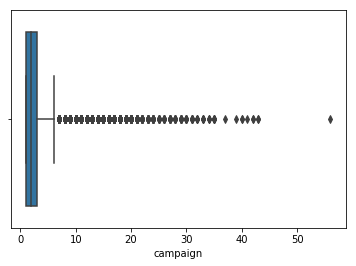

In [37]:
sns.boxplot(x = bank_market.campaign)

In [38]:
bank_market.campaign.describe([0.25,0.50,0.75,0.99])

count    41188.000000
mean         2.567593
std          2.770014
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
99%         14.000000
max         56.000000
Name: campaign, dtype: float64

#### We can see there is a huge difference between 99th percentile and the max value lets make 14 as our higher limit for all the data

### Analysis on campaign

In [39]:
bank_market['campaign'][bank_market['campaign']>14] = 14

In [40]:
bank_market.campaign.value_counts()

1     17642
2     10570
3      5341
4      2651
5      1599
6       979
7       629
14      475
8       400
9       283
10      225
11      177
12      125
13       92
Name: campaign, dtype: int64

Analysis in table format
    campaign  No.of_prospect  count_prospects  response_rate
0          1           17642             2300           13.0
1          2           10570             1211           11.5
2          3            5341              574           10.7
3          4            2651              249            9.4
4          5            1599              120            7.5
5          6             979               75            7.7
6          7             629               38            6.0
7          8             400               17            4.2
8          9             283               17            6.0
9         10             225               12            5.3
10        11             177               12            6.8
11        12             125                3            2.4
12        13              92                4            4.3
13        14             475                8            1.7


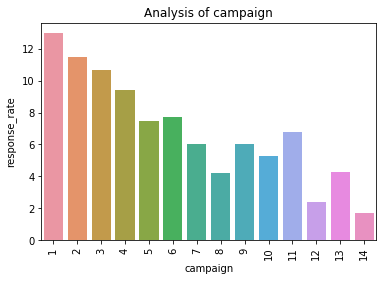

In [41]:
analize('campaign','response')

#### Response is decreasing with the number of contracts

### Gap after last contact

In [42]:
bank_market.pdays.value_counts()

999    39673
3        439
6        412
4        118
9         64
2         61
7         60
12        58
10        52
5         46
13        36
11        28
1         26
15        24
14        20
8         18
0         15
16        11
17         8
18         7
19         3
22         3
21         2
26         1
20         1
25         1
27         1
Name: pdays, dtype: int64

In [43]:
bank_market['pdays'][bank_market['pdays'].isin([0,1,2,3,4,5,6,7,8,9,10])]='Contacted_in_first_10days'
bank_market['pdays'][bank_market['pdays'].isin([999])]='First_time_contacted'
bank_market['pdays'][~bank_market['pdays'].isin(['Contacted_in_first_10days','First_time_contacted'])]='Contacted_after_10days'

In [44]:
bank_market['pdays'].value_counts()

First_time_contacted         39673
Contacted_in_first_10days     1311
Contacted_after_10days         204
Name: pdays, dtype: int64

Analysis in table format
                       pdays  No.of_prospect  count_prospects  response_rate
0     Contacted_after_10days             204              116           56.9
1  Contacted_in_first_10days            1311              851           64.9
2       First_time_contacted           39673             3673            9.3


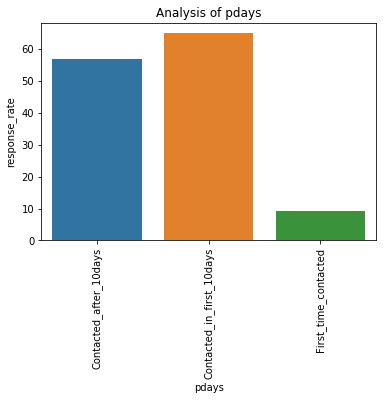

In [45]:
analize('pdays','response')

#### Though there is a huge difference in the response rates of the three categories, it is important to note that there is also a huge difference in the volume of data entries in these categories

#### Analysis in previous

In [46]:
bank_market.previous.value_counts()

0    35563
1     4561
2      754
3      216
4       70
5       18
6        5
7        1
Name: previous, dtype: int64

In [47]:
bank_market['previous'][bank_market['previous'].isin([0])]='Never contacted'
bank_market['previous'][bank_market['previous'].isin([1,2,3])]='Less_than_3_times'
bank_market['previous'][bank_market['previous'].isin([4,5,6,7])]='More than_3_times'

In [48]:
bank_market.previous.value_counts()

Never contacted      35563
Less_than_3_times     5531
More than_3_times       94
Name: previous, dtype: int64

Analysis in table format
            previous  No.of_prospect  count_prospects  response_rate
0  Less_than_3_times            5531             1445           26.1
1  More than_3_times              94               54           57.4
2    Never contacted           35563             3141            8.8


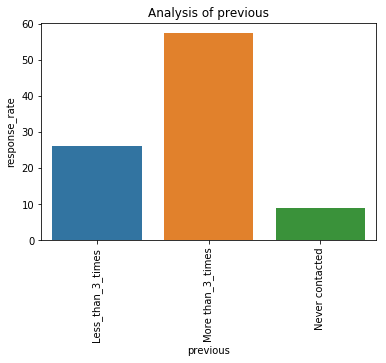

In [49]:
analize('previous','response')

#### We can note that the response rate is greatest for the the potential customers having previous contact of more than three. However, please note that the number of data entries is very low for such cases, hence it's difficult to draw any inferences.

### Analysis on Employment Variation Rate

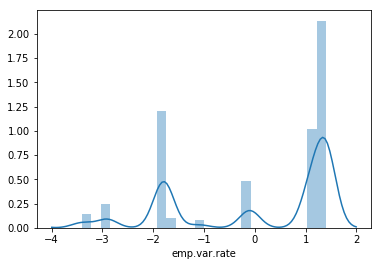

In [50]:
sns.distplot(bank_market['emp.var.rate'])
plt.show()

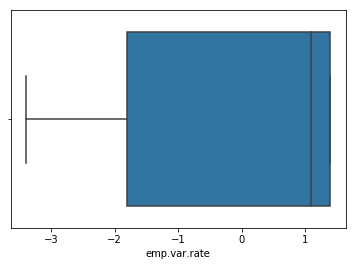

In [51]:
sns.boxplot(bank_market['emp.var.rate'])

In [52]:
bank_market['emp.var.rate'].describe([0.25,0.50,0.75,0.99])

count    41188.000000
mean         0.081886
std          1.570960
min         -3.400000
25%         -1.800000
50%          1.100000
75%          1.400000
99%          1.400000
max          1.400000
Name: emp.var.rate, dtype: float64

Analysis in table format
   emp.var.rate  No.of_prospect  count_prospects  response_rate
0          -3.4            1071              454           42.4
1          -3.0             172               88           51.2
2          -2.9            1663              594           35.7
3          -1.8            9184             1461           15.9
4          -1.7             773              403           52.1
5          -1.1             635              301           47.4
6          -0.2              10                1           10.0
7          -0.1            3683              232            6.3
8           1.1            7763              240            3.1
9           1.4           16234              866            5.3


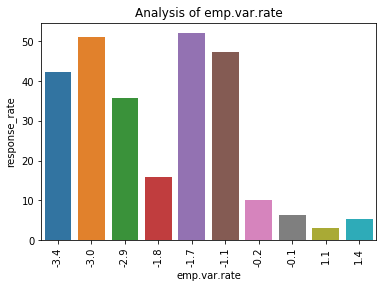

In [53]:
analize('emp.var.rate','response')

#### You can note that a negative employment variation rate seems to be related to higher response rates.

### Analysis on Consumer Price Index

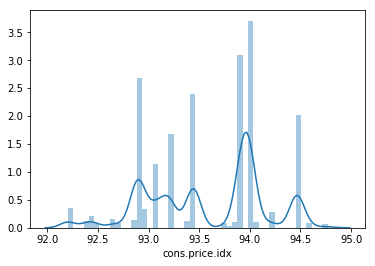

In [54]:
sns.distplot(bank_market['cons.price.idx'])
plt.show()

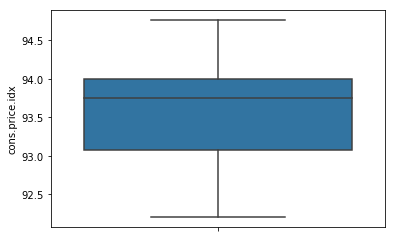

In [55]:
sns.boxplot(y=bank_market['cons.price.idx'])

In [56]:
bank_market['cons.price.idx'].describe([0.25,0.50,0.75,0.99])

count    41188.000000
mean        93.575664
std          0.578840
min         92.201000
25%         93.075000
50%         93.749000
75%         93.994000
99%         94.465000
max         94.767000
Name: cons.price.idx, dtype: float64

Analysis in table format
    cons.price.idx  No.of_prospect  count_prospects  response_rate
0           92.201             770              264           34.3
1           92.379             267              106           39.7
2           92.431             447              180           40.3
3           92.469             178               66           37.1
4           92.649             357              168           47.1
5           92.713             172               88           51.2
6           92.756              10                1           10.0
7           92.843             282              126           44.7
8           92.893            5794              524            9.0
9           92.963             715              264           36.9
10          93.075            2458              442           18.0
11          93.200            3616              190            5.3
12          93.369             264              150           56.8
13          93.444            5175   

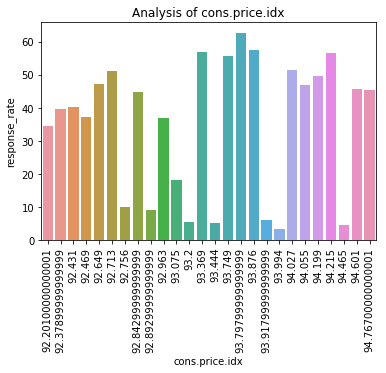

In [57]:
analize('cons.price.idx','response')

### Analysis on Number of employeees

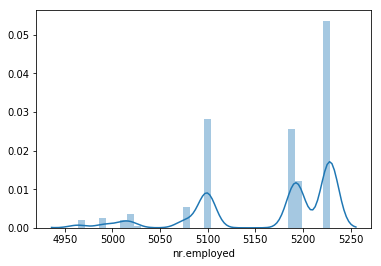

In [58]:
sns.distplot(bank_market['nr.employed'])
plt.show()

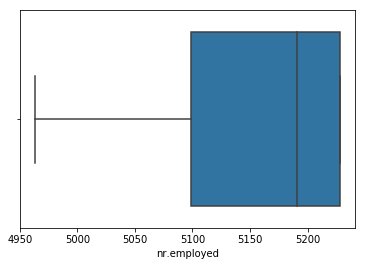

In [59]:
sns.boxplot(bank_market['nr.employed'])

In [60]:
bank_market['nr.employed'].describe([0.25,0.50,0.75,0.99])

count    41188.000000
mean      5167.035911
std         72.251528
min       4963.600000
25%       5099.100000
50%       5191.000000
75%       5228.100000
99%       5228.100000
max       5228.100000
Name: nr.employed, dtype: float64

Analysis in table format
    nr.employed  No.of_prospect  count_prospects  response_rate
0        4963.6             635              301           47.4
1        4991.6             773              403           52.1
2        5008.7             650              369           56.8
3        5017.5            1071              454           42.4
4        5023.5             172               88           51.2
5        5076.2            1663              594           35.7
6        5099.1            8534             1092           12.8
7        5176.3              10                1           10.0
8        5191.0            7763              240            3.1
9        5195.8            3683              232            6.3
10       5228.1           16234              866            5.3


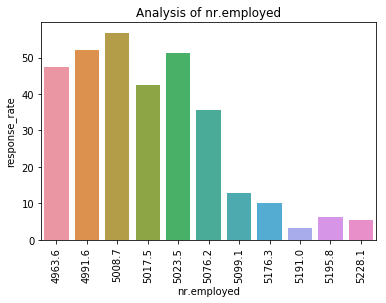

In [61]:
analize('nr.employed','response')

### Data Preparation

#### Lets drop the duration & age_bins as these are not necessary for our analysis

In [62]:
bank_market.drop(columns=['age_bins'],inplace=True)

In [63]:
bank_market.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'response'], dtype='object')

#### Creating unique id for every prospect

In [64]:
bank_market['prospect_id'] = [x for x in range(len(bank_market))]

#### Creating a function that will perform one hot encoding on the categorical columns

In [65]:
df_categorical = bank_market[['job','marital','education','default','housing','loan','contact','month','day_of_week','pdays','previous','poutcome']]
df_categorical.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,pdays,previous,poutcome
0,housemaid,married,Primary_Education,no,no,no,telephone,may,mon,First_time_contacted,Never contacted,nonexistent
1,services,married,Secondary_Education,unknown,no,no,telephone,may,mon,First_time_contacted,Never contacted,nonexistent
2,services,married,Secondary_Education,no,yes,no,telephone,may,mon,First_time_contacted,Never contacted,nonexistent
3,admin.,married,Primary_Education,no,no,no,telephone,may,mon,First_time_contacted,Never contacted,nonexistent
4,services,married,Secondary_Education,no,no,yes,telephone,may,mon,First_time_contacted,Never contacted,nonexistent


#### USing below function for OneHot Encoding

In [66]:
def oh_encode(df):
    cols = list(df.columns)
    for col in df.columns:
        dum = pd.get_dummies(df[col],prefix=col,drop_first=True)
        df = pd.concat([df,dum],axis='columns')
    return df

In [67]:
df_categorical = oh_encode(df_categorical)
df_categorical.drop(['job','marital','education','default','housing','loan',
                                      'contact','month','day_of_week','pdays','previous','poutcome'],axis=1,inplace=True)
df_categorical.head()

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_Secondary_Education,education_Tertiary_Education,education_professional.course,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,pdays_Contacted_in_first_10days,pdays_First_time_contacted,previous_More than_3_times,previous_Never contacted,poutcome_nonexistent,poutcome_success
0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1,0
1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1,0
2,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1,0
4,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1,0


In [68]:
bank_market = pd.concat([bank_market,df_categorical],axis='columns')
bank_market.drop(['job','marital','education','default','housing','loan',
                                      'contact','month','day_of_week','pdays','previous','poutcome'],axis=1,inplace=True)
bank_market.head()

,age,duration,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,response,prospect_id,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_Secondary_Education,education_Tertiary_Education,education_professional.course,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,pdays_Contacted_in_first_10days,pdays_First_time_contacted,previous_More than_3_times,previous_Never contacted,poutcome_nonexistent,poutcome_success
0,56,261,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1,0
1,57,149,1,1.1,93.994,-36.4,4.857,5191.0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1,0
2,37,226,1,1.1,93.994,-36.4,4.857,5191.0,0,2,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1,0
3,40,151,1,1.1,93.994,-36.4,4.857,5191.0,0,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1,0
4,56,307,1,1.1,93.994,-36.4,4.857,5191.0,0,4,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1,0


In [69]:
bank_market_model = bank_market

#### Lets split the data set into train and test

In [70]:
X = bank_market_model.drop(['response'],axis='columns')
y = bank_market_model['response']

In [71]:
bank_market_model.shape

(41188, 53)

In [72]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,test_size=0.3,random_state=1024)

#### Scaling using StanderdScaler

In [73]:
X_train_p_id = X_train.pop('prospect_id')
X_test_p_id = X_test.pop('prospect_id')
X_train_duration = X_train.pop('duration')
X_test_duration = X_test.pop('duration')

In [74]:
y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)

In [75]:
scale = StandardScaler()
X_train[['age','campaign','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']] = \
scale.fit_transform(X_train[['age','campaign','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']])
X_test[['age','campaign','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']] = \
scale.transform(X_test[['age','campaign','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']])

In [76]:
X_train.sample(2)

,age,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_Secondary_Education,education_Tertiary_Education,education_professional.course,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,pdays_Contacted_in_first_10days,pdays_First_time_contacted,previous_More than_3_times,previous_Never contacted,poutcome_nonexistent,poutcome_success
30972,1.473443,-0.212441,-1.190381,-1.171406,-1.228188,-1.308623,-0.938531,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,1,0
18642,0.787277,5.043844,0.839645,0.592998,-0.474787,0.777856,0.845761,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0


#### Building Logistic regression and using usual RFE for variable selection

In [77]:
cross_val_score(LogisticRegression(),X_train,y_train,cv=5,scoring='accuracy',verbose=1).mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.1s finished


0.8991363650479549

#### Lets do grid search to find the optimum number of features

In [78]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)
lm = LogisticRegression()
rfe = RFE(lm)
params = {'n_features_to_select':list(range(1, 52))}
# params = {'n_features_to_select':(10,20,30,40)}

model_cv = GridSearchCV(rfe,
                        param_grid=params,
                        scoring='accuracy',
                        cv=cv,
                        verbose=1,
                       return_train_score=True,
                       n_jobs=-1)
model_cv.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 51 candidates, totalling 255 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 255 out of 255 | elapsed: 18.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             error_score='raise-deprecating',
             estimator=RFE(estimator=LogisticRegression(C=1.0,
                                                        class_weight=None,
                                                        dual=False,
                                                        fit_intercept=True,
                                                        intercept_scaling=1,
                                                        l1_ratio=None,
                                                        max_iter=100,
                                                        multi_class='warn',
                                                        n_jobs=None,
                                                        penalty='l2',
                                                        random_state=None,
                                                        solver='warn',
                  

In [79]:
model_cv_res = pd.DataFrame(model_cv.cv_results_)

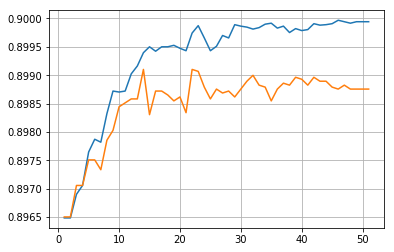

In [80]:
plt.plot(model_cv_res.param_n_features_to_select,model_cv_res.mean_train_score)
plt.plot(model_cv_res.param_n_features_to_select,model_cv_res.mean_test_score)
plt.grid()
plt.show()

In [81]:
print(model_cv.best_params_)
print(model_cv.best_score_)

{'n_features_to_select': 14}
0.8991016614061254


#### Lets select 14 feature

In [82]:
lm = LogisticRegression()
rfe = RFE(estimator=lm,n_features_to_select=14)
rfe.fit(X_train,y_train)

RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                 fit_intercept=True, intercept_scaling=1,
                                 l1_ratio=None, max_iter=100,
                                 multi_class='warn', n_jobs=None, penalty='l2',
                                 random_state=None, solver='warn', tol=0.0001,
                                 verbose=0, warm_start=False),
    n_features_to_select=14, step=1, verbose=0)

In [83]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('age', False, 37),
 ('campaign', False, 12),
 ('emp.var.rate', True, 1),
 ('cons.price.idx', True, 1),
 ('cons.conf.idx', False, 8),
 ('euribor3m', True, 1),
 ('nr.employed', False, 7),
 ('job_blue-collar', False, 5),
 ('job_entrepreneur', False, 36),
 ('job_housemaid', False, 17),
 ('job_management', False, 27),
 ('job_retired', False, 2),
 ('job_self-employed', False, 13),
 ('job_services', False, 10),
 ('job_student', True, 1),
 ('job_technician', False, 25),
 ('job_unemployed', False, 26),
 ('job_unknown', False, 21),
 ('marital_married', False, 29),
 ('marital_single', False, 23),
 ('education_Secondary_Education', False, 34),
 ('education_Tertiary_Education', False, 14),
 ('education_professional.course', False, 24),
 ('education_unknown', False, 22),
 ('default_unknown', False, 6),
 ('default_yes', False, 30),
 ('housing_unknown', False, 32),
 ('housing_yes', False, 33),
 ('loan_unknown', False, 20),
 ('loan_yes', False, 16),
 ('contact_telephone', True, 1),
 ('month_aug', Tru

#### Creating baisc GLM model for modeling

In [84]:
rfe_selected_columns = X_train.columns[rfe.support_]

In [85]:
X_train = X_train[rfe_selected_columns]

In [86]:
X_train_1 = sm.add_constant(X_train)
model_1 = sm.GLM(y_train,X_train_1,family=sm.families.Binomial()).fit()
print(model_1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                28831
Model:                            GLM   Df Residuals:                    28816
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7991.7
Date:                Mon, 04 Nov 2019   Deviance:                       15983.
Time:                        20:25:06   Pearson chi2:                 2.88e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

#### The p value  for all the variables are zero so we can conclude all the selected column as relevant

#### Above 14 are the selected variables using RFE

In [87]:
train_prob = model_1.predict(X_train_1)

### As per assignment purpose lets create a Logistic regression model

#### ** Note I have already tried SMOTE and NearMiss technique for class imbalence issue but in both the cases my model is overfitting for test data 

#### I am using class_weight parameter to handle the class imbalence problem

In [88]:
l_model = LogisticRegression(class_weight='balanced')
X_train = X_train[rfe_selected_columns]
l_model.fit(X_train,y_train)
train_prob = l_model.predict_proba(X_train)[:,1]

#### Below is the feature importence graph

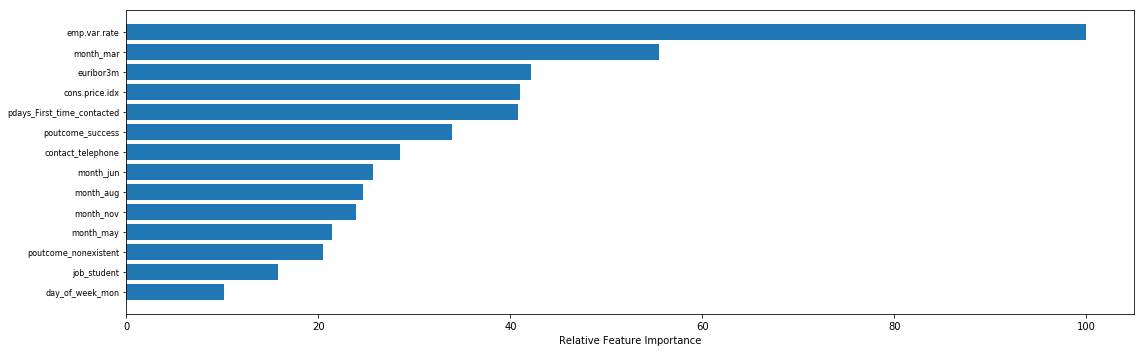

In [177]:
feature_importance = abs(l_model.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
featfig = plt.figure(figsize=(16,5))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X_train.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

#### Sorting the DataFrame in decreasing order of probability of response

In [89]:
temp =pd.DataFrame(list(zip(X_train_p_id,train_prob)) )
temp.columns = ['prospect_id','acc_prob']
X_train_new = pd.concat([X_train.reset_index(),temp],axis='columns')

In [90]:
X_train_new = X_train_new.sort_values(by='acc_prob',ascending=False)
X_train_new.head()

,index,emp.var.rate,cons.price.idx,euribor3m,job_student,contact_telephone,month_aug,month_jun,month_mar,month_may,month_nov,day_of_week_mon,pdays_First_time_contacted,poutcome_nonexistent,poutcome_success,prospect_id,acc_prob
10617,40466,-1.126942,0.780627,-1.562524,1,0,1,0,0,0,0,0,0,0,1,40466,0.988510
15979,40365,-1.126942,0.780627,-1.564251,1,0,1,0,0,0,0,0,0,0,1,40365,0.988489
28446,40368,-1.126942,0.780627,-1.564251,1,0,1,0,0,0,0,0,0,0,1,40368,0.988489
15560,40364,-1.126942,0.780627,-1.564251,1,0,1,0,0,0,0,0,0,0,1,40364,0.988489
2292,40373,-1.126942,0.780627,-1.564251,1,0,1,0,0,0,0,0,0,0,1,40373,0.988489


#### Lets find the optimal cutoff

In [91]:
opt_cutoff = pd.concat([X_train_new.acc_prob,pd.DataFrame(y_train)],axis=1)
opt_cutoff.columns = ['acc_prob','actual_prob']
opt_cutoff = pd.concat([opt_cutoff,X_train_new.prospect_id],axis=1)

In [92]:
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    opt_cutoff[i] = opt_cutoff.acc_prob.map(lambda x: 1 if x > i else 0)
opt_cutoff.head()

,acc_prob,actual_prob,prospect_id,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.353362,0,13306,1,1,1,1,0,0,0,0,0,0
1,0.212047,0,4842,1,1,1,0,0,0,0,0,0,0
2,0.480901,0,31776,1,1,1,1,1,0,0,0,0,0
3,0.304550,0,23992,1,1,1,1,0,0,0,0,0,0
4,0.353966,0,32306,1,1,1,1,0,0,0,0,0,0


In [93]:
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix(opt_cutoff.actual_prob, opt_cutoff[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.114009  1.000000  0.000000
0.1   0.1  0.114009  1.000000  0.000000
0.2   0.2  0.154521  0.988744  0.047174
0.3   0.3  0.492976  0.862489  0.445427
0.4   0.4  0.762859  0.702160  0.770670
0.5   0.5  0.832680  0.628537  0.858949
0.6   0.6  0.848323  0.606024  0.879502
0.7   0.7  0.874302  0.520535  0.919825
0.8   0.8  0.890985  0.388500  0.955645
0.9   0.9  0.898928  0.212656  0.987238


#### Finding the optimal cutoff according to the below graph the optimal cuttoff is showing as 0.3

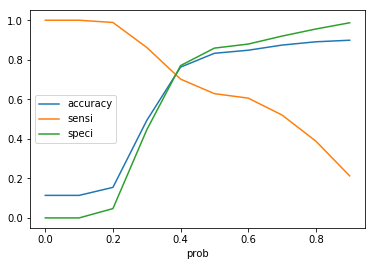

In [94]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

#### We can see that the selected optimal cutoff is 0.4

In [95]:
opt_cutoff['final_pred'] = opt_cutoff.acc_prob.map(lambda x : 1 if x>0.4 else 0)

In [96]:
opt_cutoff.head()

,acc_prob,actual_prob,prospect_id,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_pred
0,0.353362,0,13306,1,1,1,1,0,0,0,0,0,0,0
1,0.212047,0,4842,1,1,1,0,0,0,0,0,0,0,0
2,0.480901,0,31776,1,1,1,1,1,0,0,0,0,0,1
3,0.304550,0,23992,1,1,1,1,0,0,0,0,0,0,0
4,0.353966,0,32306,1,1,1,1,0,0,0,0,0,0,0


In [97]:
accuracy_score(opt_cutoff.actual_prob,opt_cutoff.final_pred)

0.7628594221497693

In [98]:
print(classification_report(opt_cutoff.actual_prob,opt_cutoff.final_pred))

              precision    recall  f1-score   support

           0       0.95      0.77      0.85     25544
           1       0.28      0.70      0.40      3287

    accuracy                           0.76     28831
   macro avg       0.62      0.74      0.63     28831
weighted avg       0.88      0.76      0.80     28831



In [99]:
confusion_matrix(opt_cutoff.actual_prob,opt_cutoff.final_pred)

array([[19686,  5858],
       [  979,  2308]], dtype=int64)

In [100]:
roc_auc_score(opt_cutoff.actual_prob,opt_cutoff.final_pred)

0.736415120218008

In [101]:
precision_score(opt_cutoff.actual_prob,opt_cutoff.final_pred)

0.28263531716874846

In [102]:
recall_score(opt_cutoff.actual_prob,opt_cutoff.final_pred)

0.7021600243383024

#### Lets try the prediction on the test data

In [103]:
X_test = X_test[rfe_selected_columns]
# X_test = sm.add_constant(X_test)
test_df_pred = l_model.predict_proba(X_test)[:,1]
test_df_pred = pd.DataFrame(test_df_pred).reset_index()
y_test = pd.DataFrame(y_test)

In [104]:
test_df_new = pd.concat([test_df_pred,y_test],axis=1)
test_df_new = test_df_new.drop('index',axis='columns')
test_df_new.columns = ['pred_prob','actual']

In [105]:
test_df_new['pred_class'] = test_df_new.pred_prob.map(lambda x : 1 if x>0.4 else 0)
test_df_new.head()

,pred_prob,actual,pred_class
0,0.743247,1,1
1,0.211843,0,0
2,0.172266,0,0
3,0.358745,0,0
4,0.211740,0,0


In [106]:
accuracy_score(test_df_new.actual,test_df_new.pred_class)

0.7585174395079712

In [107]:
print(classification_report(test_df_new.actual,test_df_new.pred_class))

              precision    recall  f1-score   support

           0       0.95      0.77      0.85     11004
           1       0.27      0.68      0.38      1353

    accuracy                           0.76     12357
   macro avg       0.61      0.72      0.62     12357
weighted avg       0.88      0.76      0.80     12357



In [108]:
confusion_matrix(test_df_new.actual,test_df_new.pred_class)

array([[8451, 2553],
       [ 431,  922]], dtype=int64)

In [109]:
roc_auc_score(test_df_new.actual,test_df_new.pred_class)

0.7247210447964497

In [110]:
roc_auc_score(test_df_new.actual,test_df_new.pred_class)

0.7247210447964497

In [111]:
from sklearn.metrics import roc_curve
fpr,tpr,thresh = roc_curve(test_df_new.actual,test_df_new.pred_prob)

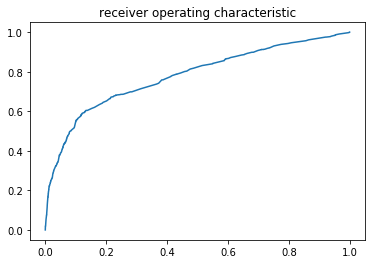

In [112]:
plt.plot(fpr,tpr)
plt.title('receiver operating characteristic')
plt.show()

In [113]:
log_loss(test_df_new.actual,test_df_new.pred_class)

8.340677359767966

#### We can see the log loss is very high but for a basic logistic regression model this is ok

#### Creating a data frame with the variables prospect ID, actual response, predicted response, predicted probability of response, duration of the call in seconds and cost of the call

#### Performing this operations on the test dataset

In [114]:
X_test_p_id = X_test_p_id.reset_index()
test_df_new = pd.concat([test_df_new,X_test_p_id],axis='columns')
test_df_new = test_df_new.drop('index',axis='columns')

In [115]:
X_test_duration = pd.DataFrame(X_test_duration)
X_test_duration = X_test_duration.reset_index()
X_test_duration = X_test_duration.drop('index',axis=1)

In [116]:
test_df_new=pd.concat([test_df_new,X_test_duration],axis='columns')

#### Lets assume that the cost of call for 1 min is 1 rupees  as the duration is in seconds so i am deviding that with 60

In [117]:
test_df_new['cost_per_call'] = test_df_new.duration/60 * 1 

In [118]:
test_df_new.columns= ['predicted_probability','actual_response','predicted_response','prospect_id','duration','cost_of_the_call']

In [119]:
test_df_new.head()

,predicted_probability,actual_response,predicted_response,prospect_id,duration,cost_of_the_call
0,0.743247,1,1,37771,712,11.866667
1,0.211843,0,0,2371,147,2.450000
2,0.172266,0,0,2097,832,13.866667
3,0.358745,0,0,24834,214,3.566667
4,0.211740,0,0,1720,646,10.766667


#### Above dataframe we can see  cost of call for each prospect 

#### Finding the number of top X% prospects you should target to meet the business objective

In [120]:
decile_df = test_df_new
decile_df = decile_df.drop(['prospect_id','duration','cost_of_the_call'],axis='columns')

In [121]:
decile_df['decile'] = pd.qcut(decile_df['predicted_probability'], 10, labels=np.arange(10, 0, -1))

In [122]:
lift_df = decile_df.groupby('decile')['predicted_probability'].count().reset_index()
lift_df.rename({'predicted_probability':'total'}, axis=1, inplace=True)
lift_df_pred = decile_df[decile_df['actual_response']==1].groupby('decile')['actual_response'].count().reset_index()
lift_df_final = lift_df.merge(lift_df_pred,on = 'decile')
lift_df_final = lift_df_final.sort_values(['decile'], ascending=False)
lift_df_final['cumresp'] = lift_df_final['actual_response'].cumsum()
lift_df_final['gain'] = 100*(lift_df_final['cumresp']/sum(lift_df_final['actual_response']))
lift_df_final['cumlift'] = lift_df_final['gain']/(lift_df_final['decile'].astype('int')*(100/10))

In [123]:
lift_df_final['base_line']= (lift_df_final.actual_response/lift_df_final.total.sum())*100

In [124]:
lift_df_final

,decile,total,actual_response,cumresp,gain,cumlift,base_line
9,1,1235,579,579,42.793792,4.279379,4.685603
8,2,1190,246,825,60.975610,3.048780,1.990774
7,3,1235,103,928,68.588322,2.286277,0.833536
6,4,1109,57,985,72.801183,1.820030,0.461277
5,5,1348,99,1084,80.118256,1.602365,0.801165
4,6,1264,64,1148,84.848485,1.414141,0.517925
3,7,1122,60,1208,89.283075,1.275472,0.485555
2,8,1291,62,1270,93.865484,1.173319,0.501740
1,9,1027,31,1301,96.156689,1.068408,0.250870
0,10,1536,52,1353,100.000000,1.000000,0.420814


#### Note that you can attain 80% of total conversions by targeting only 50% of the total client base. This can be used in cost optimization and depending on the cost per call, we can determine, how many people should be part of the  marketing campaign

In [125]:
# Selecting to 50% and calculating the average call duration
top_50 = test_df_new[test_df_new.predicted_response==1].sort_values(by='predicted_probability',ascending=False)

In [126]:
print('Total responders={}'.format(top_50.shape[0]))

Total responders=3475


In [127]:
ind = round(len(top_50)*0.5)
top_50 = top_50.iloc[:ind]

In [128]:
print('Top 80% of the responders={}'.format(top_50.shape[0]))

Top 80% of the responders=1738


In [129]:
print('Average Call duration for targetting 50% customer :{} sec'.format(top_50.duration.mean()))

Average Call duration for targetting 50% customer :286.626582278481 sec


#### Average Call duration for targetting 50% customer :286.626582278481 sec

### Lift Chart

In [130]:
numbers = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
df = []
for am in numbers:
    df.append(round(len(test_df_new)*am))

In [131]:
df = pd.DataFrame(df)
df.columns = ['number_of_customers']
lift_df_final = pd.concat([lift_df_final,df],axis='columns')

In [132]:
lift_df_final.sort_values(by='decile',ascending=False)

,decile,total,actual_response,cumresp,gain,cumlift,base_line,number_of_customers
9,1,1235,579,579,42.793792,4.279379,4.685603,12357
8,2,1190,246,825,60.975610,3.048780,1.990774,11121
7,3,1235,103,928,68.588322,2.286277,0.833536,9886
6,4,1109,57,985,72.801183,1.820030,0.461277,8650
5,5,1348,99,1084,80.118256,1.602365,0.801165,7414
4,6,1264,64,1148,84.848485,1.414141,0.517925,6178
3,7,1122,60,1208,89.283075,1.275472,0.485555,4943
2,8,1291,62,1270,93.865484,1.173319,0.501740,3707
1,9,1027,31,1301,96.156689,1.068408,0.250870,2471
0,10,1536,52,1353,100.000000,1.000000,0.420814,1236


Text(0,0.5,'Respnse Rate')

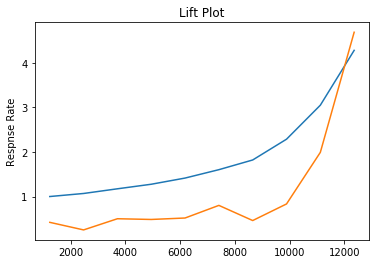

In [133]:
plt.plot(lift_df_final.number_of_customers,lift_df_final.cumlift)
plt.plot(lift_df_final.number_of_customers,lift_df_final.base_line)
# plt.plot(lift_df_final.number_of_customers,lift_df_final.decile.astype(int))
plt.title('Lift Plot')
plt.ylabel('Respnse Rate')

#### Determine the cost of acquisition 

#### cost incurred for acquiring 80% of customers using the predictive model

In [134]:
total_cost = test_df_new.cost_of_the_call.sum()
print('Total cost for conducting the entire campaign is {}'.format(total_cost))

Total cost for conducting the entire campaign is 53298.799999999996


#### Total cost for conducting the entire campaign is 53298.799999999996

In [135]:
top_80_client_cost = top_50.cost_of_the_call.sum()
print('Cost for targeting 80% of the customer is {}'.format(top_80_client_cost))

Cost for targeting 80% of the customer is 8302.616666666667


#### Cost for targeting 80% of the customer is 8302.616666666667

In [136]:
expense_saved = total_cost - top_80_client_cost
print('So we can save by targeting 80% ={}'.format(expense_saved))

So we can save by targeting 80% =44996.18333333333


#### So we can save by targeting 80% =44996.18333333333

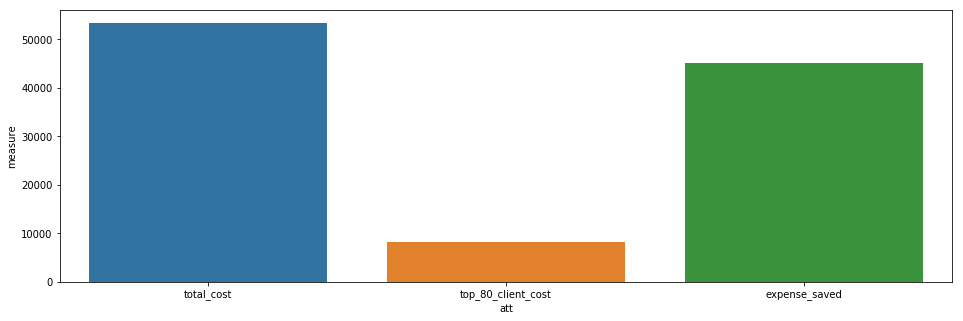

In [193]:
expense = pd.DataFrame([['total_cost', total_cost], ['top_80_client_cost', top_80_client_cost], 
                        ['expense_saved', expense_saved]],columns=['att','measure'] )
plt.figure(figsize=(16,5))
sns.barplot(expense.att,expense.measure)
plt.show()

## Extra Lets create a model that will increase the accuracy

In [137]:
from xgboost.sklearn import XGBClassifier

In [138]:
params = {
    'max_depth':[3,4,5,6],
    'min_child_weight':[1,3,5],
    'gamma':[0.1,0.2,0.3],
    'learning_rate':[0.1,0.01,0.2],
    'colsample_byree':[0.3,0.4,0.5,0.7]
}

In [139]:
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [140]:
smote = SMOTE()
X_train_sm,y_train_sm = smote.fit_resample(X_train,y_train)

In [141]:
fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
boost = XGBClassifier()
randomSearch = RandomizedSearchCV(estimator=boost,param_distributions=params,n_iter=5,cv=fold,n_jobs=-1,verbose=3,
                                 return_train_score=True)
randomSearch.fit(X_train_sm,y_train_sm)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.6min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None...
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='warn', n_iter=5, n_jobs=-1,
                   param

In [142]:
randomSearch.best_params_

{'min_child_weight': 5,
 'max_depth': 6,
 'learning_rate': 0.2,
 'gamma': 0.1,
 'colsample_byree': 0.5}

In [143]:
X_test = X_test.values

In [144]:
xgb_pred = randomSearch.best_estimator_.predict(X_test)

In [145]:
accuracy_score(y_test,xgb_pred)

0.8436513716921583

In [146]:
print(classification_report(y_test,xgb_pred))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91     11004
           1       0.37      0.58      0.45      1353

    accuracy                           0.84     12357
   macro avg       0.65      0.73      0.68     12357
weighted avg       0.88      0.84      0.86     12357



In [147]:
log_loss(y_test,xgb_pred)

5.400178639270022

In [148]:
roc_auc_score(y_test,xgb_pred)

0.7284427311656878

In [149]:
confusion_matrix(y_test,xgb_pred)

array([[9639, 1365],
       [ 567,  786]], dtype=int64)

#### Lets create GradientBoostingClassifier

In [150]:
from sklearn.ensemble import GradientBoostingClassifier

In [151]:
param = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 
           'n_estimators':[100,250,500,750,1000,1250,1500,1750],
        'max_depth': [4,8,10],
    'min_samples_leaf': range(100, 400, 200),
    'min_samples_split': range(200, 500, 200),
    'n_estimators': [100,200, 300], 
    'max_features': [5, 10]}

grid = RandomizedSearchCV(estimator =GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_distributions = param, scoring='accuracy',n_jobs=4,iid=False, cv=5,verbose=3)
grid.fit(X_train_sm,y_train_sm)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  5.2min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 10.3min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=4,
                                                        max_features='sqrt',
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                   

In [152]:
grid.best_score_

0.7662859145951078

In [153]:
gradient_out = grid.best_estimator_.predict(X_test)

In [154]:
print(classification_report(gradient_out,y_test))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     10294
           1       0.56      0.37      0.45      2063

    accuracy                           0.85     12357
   macro avg       0.72      0.66      0.68     12357
weighted avg       0.83      0.85      0.83     12357



In [155]:
roc_auc_score(gradient_out,y_test)

0.6556855213862233

In [156]:
accuracy_score(gradient_out,y_test)

0.8467265517520434

In [157]:
log_loss(gradient_out,y_test)

5.293915663481388

In [158]:
confusion_matrix(gradient_out,y_test)

array([[9702,  592],
       [1302,  761]], dtype=int64)

#### Lets create a very basic ANN

In [159]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,LeakyReLU
import tensorflow
import keras

In [160]:
print(X_train_sm.shape)
print(y_train_sm.shape)

(51088, 14)
(51088,)


In [161]:
y_train_sm = keras.utils.to_categorical(y_train_sm)

In [162]:
model = Sequential()
model.add(Dense(32,activation='relu',kernel_initializer='normal',input_dim=X_train_sm.shape[1]))
model.add(Dense(16,activation='relu',kernel_initializer='normal'))
model.add(Dropout(0.25))
model.add(Dense(8,activation='relu',kernel_initializer='normal'))
model.add(Dropout(0.25))
model.add(Dense(2,activation='sigmoid',kernel_initializer='normal'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [163]:
model.compile(optimizer='sgd',metrics=['accuracy'],loss='categorical_crossentropy')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 18        
Total params: 1,162
Trainable params: 1,162
Non-trainable params: 0
_________________________________________________________________


In [164]:
model.fit(X_train_sm,y_train_sm,batch_size=32,epochs=50,shuffle=True,verbose=1,validation_split=0.2)

Train on 40870 samples, validate on 10218 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
40870/40870 [==============================] - 5s 120us/sample - loss: 0.6710 - acc: 0.6250 - val_loss: 0.9179 - val_acc: 0.0000e+00
Epoch 2/50
40870/40870 [==============================] - 4s 105us/sample - loss: 0.6620 - acc: 0.6250 - val_loss: 0.9663 - val_acc: 0.0000e+00
Epoch 3/50
40870/40870 [==============================] - 4s 100us/sample - loss: 0.6615 - acc: 0.6250 - val_loss: 0.9819 - val_acc: 0.0000e+00
Epoch 4/50
40870/40870 [==============================] - 4s 102us/sample - loss: 0.6615 - acc: 0.6250 - val_loss: 0.9797 - val_acc: 0.0000e+00
Epoch 5/50
40870/40870 [==============================] - 4s 100us/sample - loss: 0.6615 - acc: 0.6250 - val_loss: 0.9784 - val_acc: 0.0000e+00
Epoch 6/50
40870/40870 [==============================] - 4s 98us/sample - loss: 0.6614 - acc: 0.6250 - val_loss: 0.9783 - val_acc: 0.0000e+00
Epoch 7/50
40870/40870 [===============

In [165]:
ann_pred = model.predict(X_test)

In [166]:
ann_pred = [np.argmax(y) for y in ann_pred]

In [167]:
log_loss(y_test,ann_pred)

4.734931163018845

In [168]:
print(classification_report(y_test,ann_pred))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92     11004
           1       0.41      0.54      0.46      1353

    accuracy                           0.86     12357
   macro avg       0.67      0.72      0.69     12357
weighted avg       0.88      0.86      0.87     12357



In [169]:
roc_auc_score(y_test,ann_pred)

0.7214308685170722

In [170]:
f1_score(y_test,ann_pred)

0.4632446134347275

In [171]:
confusion_matrix(y_test,ann_pred)

array([[9932, 1072],
       [ 622,  731]], dtype=int64)